In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Import Required Libraries**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axisartist.axislines import Subplot
from copy import copy, deepcopy
import pytz
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from scipy.stats import boxcox
from pickle import dump, load

from sklearn.ensemble import RandomForestRegressor

from matplotlib.dates import num2date
from matplotlib.ticker import Formatter
from datetime import datetime

For Formatting Console Print Commands - ANSI Escape Code

In [3]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

# **Import Data**


In [4]:
scaler = load(open('/content/drive/My Drive/Colab Notebooks/Electricity Forecasting/data/scaler.pkl', 'rb'))
officeTS = load(open('/content/drive/My Drive/Colab Notebooks/Electricity Forecasting/data/officeTS.pkl', 'rb'))

trainSplit = load(open('/content/drive/My Drive/Colab Notebooks/Electricity Forecasting/data/trainSplit.pkl', 'rb'))
testSplit = load(open('/content/drive/My Drive/Colab Notebooks/Electricity Forecasting/data/testSplit.pkl', 'rb'))
dateTrainSplit = load(open('/content/drive/My Drive/Colab Notebooks/Electricity Forecasting/data/dateTrainSplit.pkl', 'rb'))
dateTestSplit = load(open('/content/drive/My Drive/Colab Notebooks/Electricity Forecasting/data/dateTestSplit.pkl', 'rb'))

In [5]:
# Perform Standardization
trainScaled = np.transpose(scaler.transform(np.transpose(trainSplit)))
testScaled = np.transpose(scaler.transform(np.transpose(testSplit)))

print(trainScaled.shape)
print(testScaled.shape)

(11, 46760)
(11, 11704)


# **Utility Functions**

In [6]:
# Make Windows
def makeWindowsFromContinuousSteps(officesData, dateData, history, leadSteps):
    '''
    officesData     : 2-D Numpy Array (number of offices, total number of readings)
    dateData        : 2-D Numpy Array (number of offices, total number of readings)
    history         : Number of TIMESTEPS to be considered as Input to Forecasting Model
    leadSteps       : Number of TIMESTEPS to be considered as Output to Forecasting Model
    '''
    dataX, dataY, officeNumber = [], [], []
    dateX, dateY = [], []
    idxWindows = []

    # If only 1 office data is present, i.e. shape of officesData is
    # (total number of readings,), then reshape to (1, total number of readings)
    if len(officesData.shape)==1:
        officesData = officesData.reshape(1,-1)
    elif not len(officesData.shape)==2:
        raise('Unacceptable input shape of officesData variable - ' + str(officesData.shape))
    
    # If only 1 date data is present, i.e. shape of dateData is
    # (total number of readings,), then reshape to (1, total number of readings)
    if len(dateData.shape)==1:
        dateData = dateData.reshape(1,-1)
    elif not len(dateData.shape)==2:
        raise('Unacceptable input shape of dateData variable - ' + str(dateData.shape))

    for i in range(officesData.shape[0]):
        continuousSubSequenceStartIndex = 0
        continuousSubSequenceStopIndex  = 0
        searchingForNAN = True
        seqCounter = 0
        while seqCounter<len(officesData[i]):
            if seqCounter==len(officesData[i])-1:
                if np.isnan(officesData[i, seqCounter]):
                    continuousSubSequenceStopIndex = seqCounter - 1
                else:
                    continuousSubSequenceStopIndex = seqCounter
                ### Perform continuousSubSequence Operation - Extract Windows ###
                if continuousSubSequenceStopIndex - continuousSubSequenceStartIndex + 1 >= history + leadSteps:
                    for k in range(continuousSubSequenceStartIndex, continuousSubSequenceStopIndex+1):
                        if k + history + leadSteps <= continuousSubSequenceStopIndex + 1:
                            dataX.append(officesData[i, k:k+history])
                            dataY.append(officesData[i, k+history:k+history+leadSteps])
                            officeNumber.append(i)
                            dateX.append(dateData[i, k:k+history])
                            dateY.append(dateData[i, k+history:k+history+leadSteps])
                            idxWindows.append((i, k))
                break
            if not np.isnan(officesData[i, seqCounter]):
                if not searchingForNAN:
                    searchingForNAN = True
                    continuousSubSequenceStartIndex = seqCounter
            else:
                if searchingForNAN:
                    searchingForNAN = False
                    continuousSubSequenceStopIndex = seqCounter - 1
                    ### Perform continuousSubSequence Operation - Extract Windows ###
                    if continuousSubSequenceStopIndex - continuousSubSequenceStartIndex + 1 >= history + leadSteps:
                        for k in range(continuousSubSequenceStartIndex, continuousSubSequenceStopIndex+1):
                            if k + history + leadSteps <= continuousSubSequenceStopIndex + 1:
                                dataX.append(officesData[i, k:k+history])
                                dataY.append(officesData[i, k+history:k+history+leadSteps])
                                officeNumber.append(i)
                                dateX.append(dateData[i, k:k+history])
                                dateY.append(dateData[i, k+history:k+history+leadSteps])
                                idxWindows.append((i, k))
            seqCounter += 1
    return dataX, dataY, officeNumber, dateX, dateY, idxWindows

In [7]:
def calcInvScaledError(scaledPrediction, scaledTruth, errorMetric='RMSE', scaler=None, dataToScalerIndices=None):
    if scaler is not None:
        if dataToScalerIndices is None:
            if len(scaler.mean_) > 1:
                raise("Different scaler used for different datapoints but back reference is not provided - dataToScalerIndices is None!")
            else:
                inv_scaledPrediction = np.transpose(scaler.inverse_transform(np.transpose(scaledPrediction)))
                inv_scaledTruth = np.transpose(scaler.inverse_transform(np.transpose(scaledTruth)))
        else:
            inv_scaledPrediction = deepcopy(scaledPrediction)
            inv_scaledTruth = deepcopy(scaledTruth)
            for i in range(len(scaledPrediction)):
                inv_scaledPrediction[i,:] = (scaledPrediction[i,:]*(scaler.mean_[dataToScalerIndices[i]]))+np.sqrt(scaler.var_[dataToScalerIndices[i]])
                inv_scaledTruth[i,:] = (scaledTruth[i,:]*(scaler.mean_[dataToScalerIndices[i]]))+np.sqrt(scaler.var_[dataToScalerIndices[i]])
        prediction = inv_scaledPrediction
        truth = inv_scaledTruth
    else:
        prediction = scaledPrediction
        truth = scaledTruth
    if errorMetric=='RMSE':
        error = mean_squared_error(truth, prediction, squared=False)
    elif errorMetric=='MSE':
        error = mean_squared_error(truth, prediction, squared=True)
    else:
        raise('Unsupported error metric - ' + errorMetric)
    return error

In [8]:
# Inverse Transform the Standardization Process
def invertStandardization(scaler, data, officeNumber):
    '''
    # Params::
    scaler          : sklearn StandardScaler object which was used to perform standardization
    data            : ndarray of shape (number of windows, time-steps)
    officeNumber    : ndarray of shape (number of windows) - specifying the office number to which a window belongs

    # Returns::
    data_tr         : ndarray of shape (number of windows, time-steps)
    '''
    mean = scaler.mean_
    std  = np.sqrt(scaler.var_)
    data_tr = np.zeros((data.shape))
    for i in range(data.shape[0]):
        data_tr[i,:] = (data[i,:]*std[officeNumber[i]]) + mean[officeNumber[i]]
    return data_tr

# **Main Code Starts Here**

In [9]:
# Selected Working Hours: start_time - end_time (MON-FRI)
start_time = 5
end_time = 19

# Calculate total number of days and readings per day
readingsPerDay = (end_time-start_time)*4
totalDays = int(officeTS.shape[1]/readingsPerDay)
print('Readings Per Day = ', readingsPerDay)
print('Total Number of Days = ', totalDays)

# History and Lead Time
historySteps = 5*readingsPerDay #== 5 Days
leadSteps = 1*readingsPerDay #== 1 Day

Readings Per Day =  56
Total Number of Days =  1044


In [22]:
officeIDX = 4

trainX, trainY, officeNumberTrain, dateTrainX, dateTrainY, idxWindows = makeWindowsFromContinuousSteps(trainScaled[officeIDX], dateTrainSplit[officeIDX], historySteps, leadSteps)
print(len(trainX), len(trainY), len(officeNumberTrain), officeNumberTrain[0])
print(trainX[0].shape, trainY[0].shape)
testX, testY, officeNumberTest, dateTestX, dateTestY, idxWindows = makeWindowsFromContinuousSteps(testScaled[officeIDX], dateTestSplit[officeIDX], historySteps, leadSteps)
print(len(testX), len(testY), len(officeNumberTest), officeNumberTest[0])
print(testX[0].shape, testY[0].shape)

46425 46425 46425 0
(280,) (56,)
10640 10640 10640 0
(280,) (56,)


**Do Hyperparameter Tuning**

In [13]:
my_trainX = trainX[:int(len(trainX)*0.8)]
my_trainY = trainY[:int(len(trainY)*0.8)]

my_valX = trainX[int(len(trainX)*0.8):]
my_valY = trainY[int(len(trainY)*0.8):]

max_maxDepth = 25
error_train = np.zeros(max_maxDepth)
error_val = np.zeros(max_maxDepth)
for i in range(1,max_maxDepth+1):
    print('Iteration Number = ', i)
    RFmodel = RandomForestRegressor(max_depth=i, random_state=51, n_jobs=-1)
    RFmodel.fit(my_trainX, my_trainY)
    RF_forecast_train = RFmodel.predict(my_trainX)
    error_train[i-1] = calcInvScaledError(np.array(RF_forecast_train), np.array(my_trainY),
                                        errorMetric='RMSE', scaler=scaler, dataToScalerIndices=[officeIDX]*len(RF_forecast_train))
    RF_forecast_val = RFmodel.predict(my_valX)
    error_val[i-1] = calcInvScaledError(np.array(RF_forecast_val), np.array(my_valY),
                                      errorMetric='RMSE', scaler=scaler, dataToScalerIndices=[officeIDX]*len(RF_forecast_val))
    # save the error logs
    dump(error_train, open('/content/drive/My Drive/Colab Notebooks/Electricity Forecasting/models/RFmaxDepth_error_train'+str(officeIDX)+'.pkl', 'wb'))
    dump(error_val, open('/content/drive/My Drive/Colab Notebooks/Electricity Forecasting/models/RFmaxDepth_error_val'+str(officeIDX)+'.pkl', 'wb'))

Iteration Number =  1


KeyboardInterrupt: ignored

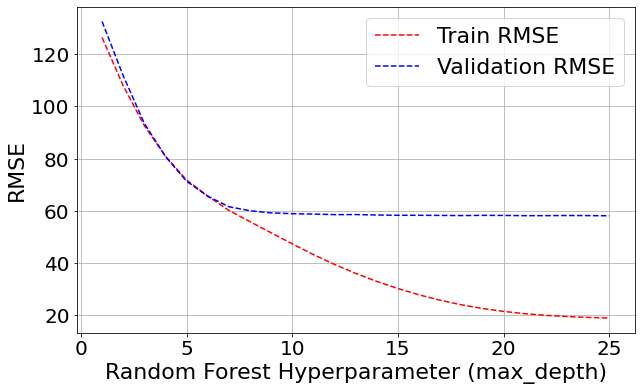

In [ ]:
# Visualize loss history
plt.figure(figsize=(10, 6))
plt.rc('font', size=17)         # controls default text sizes
plt.rc('axes', titlesize=22)    # fontsize of the axes title
plt.rc('axes', labelsize=22)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)   # fontsize of the tick labels
plt.rc('ytick', labelsize=20)   # fontsize of the tick labels
plt.rc('legend', fontsize=22)   # legend fontsize
plt.rc('figure', titlesize=25)  # fontsize of the figure title
plt.plot(range(1,max_maxDepth+1), error_train, 'r--', label='Train RMSE')
plt.plot(range(1,max_maxDepth+1), error_val, 'b--', label='Validation RMSE')
plt.xlabel('Random Forest Hyperparameter (max_depth)')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)

**Train the Random Forest Model with Optimal Hyperparameters**

In [23]:
RFmodel = RandomForestRegressor(max_depth=10, random_state=51, n_jobs=-1)
RFmodel.fit(trainX, trainY)

RandomForestRegressor(max_depth=10, n_jobs=-1, random_state=51)

In [24]:
# save the model
dump(RFmodel, open('/content/drive/My Drive/Colab Notebooks/Electricity Forecasting/models/RFmodel_'+str(officeIDX)+'.pkl', 'wb'))

In [25]:
nSamplesFromTest = len(testX)
RF_forecast = RFmodel.predict(testX[:nSamplesFromTest])
print('RMSE for Random Forest Forecast on Test Set = ', calcInvScaledError(np.array(RF_forecast), np.array(testY)[:nSamplesFromTest],
                                                                           errorMetric='RMSE', scaler=scaler, dataToScalerIndices=[officeIDX]*len(RF_forecast)))

RMSE for Random Forest Forecast on Test Set =  13.270789922483345


In [14]:
# Forecast
window_idx_to_forecast = 10762

# Create Pandas Series for Index Matching while Plotting
completeSeries = pd.Series(np.concatenate((testX[window_idx_to_forecast], testY[window_idx_to_forecast])))
seriesX = completeSeries[:len(testX[window_idx_to_forecast])]
seriesY = completeSeries[len(testX[window_idx_to_forecast]):]

completeDateSeries = pd.Series(np.concatenate((dateTestX[window_idx_to_forecast], dateTestY[window_idx_to_forecast])))
dateSeriesX = completeDateSeries[:len(dateTestX[window_idx_to_forecast])]
dateSeriesY = completeDateSeries[len(dateTestX[window_idx_to_forecast]):]

In [15]:
class MyFormatter(Formatter):
    def __init__(self, dates, fmt='%d-%m-%Y\n%H:%M:%S'):
        self.dates = dates
        self.fmt = fmt

    def __call__(self, x, pos=0):
        'Return the label for time x at position pos'
        ind = int(np.round(x))
        if ind >= len(self.dates) or ind < 0:
            return ''
        ts = (self.dates[ind] - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
        return datetime.utcfromtimestamp(ts).strftime(self.fmt)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  # This is added back by InteractiveShellApp.init_path()


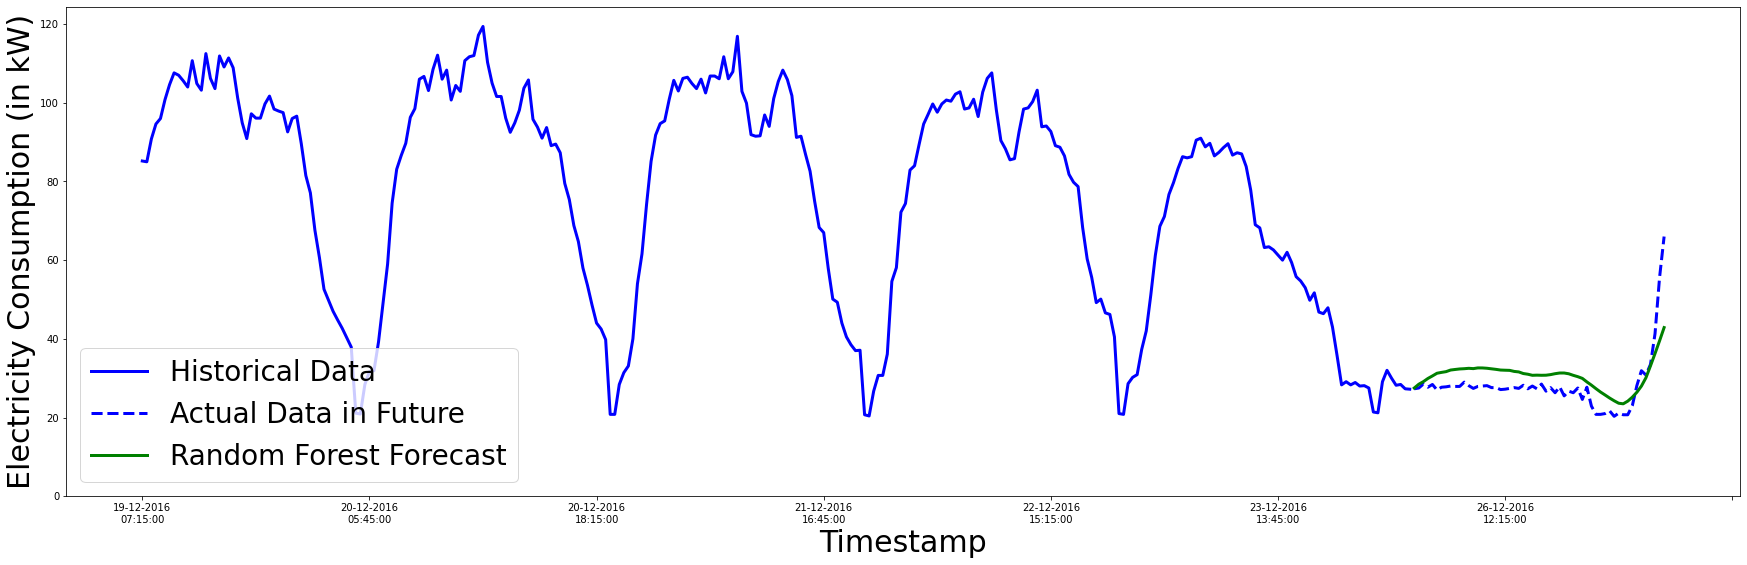

In [16]:
# Make as pandas series
RF_forecast_series = pd.Series(RF_forecast[window_idx_to_forecast], index=dateSeriesY.index)

RF_forecast_seriesTT = pd.Series(invertStandardization(scaler, np.array([RF_forecast_series]), np.array([officeIDX]))[0], index=dateSeriesY.index)

seriesXTT = pd.Series(invertStandardization(scaler, np.array([seriesX]), np.array([officeIDX]))[0], index=dateSeriesX.index)
seriesYTT = pd.Series(invertStandardization(scaler, np.array([seriesY]), np.array([officeIDX]))[0], index=dateSeriesY.index)

# Plot
formatter = MyFormatter(np.append(dateTestX[window_idx_to_forecast], dateTestY[window_idx_to_forecast]))
fig, ax = plt.subplots(figsize=(30, 9))
ax.xaxis.set_major_formatter(formatter)
plt.rc('font', size=17)         # controls default text sizes
plt.rc('axes', titlesize=30)    # fontsize of the axes title
plt.rc('axes', labelsize=30)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=26)   # fontsize of the tick labels
plt.rc('ytick', labelsize=26)   # fontsize of the tick labels
plt.rc('legend', fontsize=28)   # legend fontsize
plt.rc('figure', titlesize=35)  # fontsize of the figure title
plt.plot(seriesXTT, label='Historical Data', color='blue', marker='', linestyle='-', linewidth=3, markersize=2)
plt.plot(seriesYTT, label='Actual Data in Future', color='blue', marker='', linestyle='--', linewidth=3, markersize=2)
plt.plot(RF_forecast_seriesTT, label='Random Forest Forecast', color='green', marker='', linestyle='-', linewidth=3, markersize=2)
plt.xlabel("Timestamp", fontsize=30)
plt.ylabel("Electricity Consumption (in kW)", fontsize=30)
#plt.title('Forecast vs Actuals')
plt.legend(loc='lower left', fontsize=28)
plt.gca().set_ylim(bottom=0)
plt.show()